In [1]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [2]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

### Imports

In [4]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState
import importlib

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl

from pltStyle import pltStyle
import os
# %matplotlib notebook 

### Parameters of the run

In [5]:
UsingDaskExecutor = False
CERNCondorCluster = False
CoffeaCasaEnv     = False
load_preexisting  = False    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True   ### True if run only on one file
load_fit_res      = False   ### True if don't repeat the response fits

fine_etabins      = False   ### Don't merge eta bins together when fitting responses. Preprocessing always done in many bins
one_bin           = False   ### Unite all eta and pt bins in one

Nfiles = 100                 ### -1 for all files

tag = '_L5'                 ### L5 or L23, but L23 not supported since ages

### name of the specific run:
# add_tag = '_LHEflav1_TTBAR-Summer16-cFlip' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
# add_tag='_fine_etaBins'+add_tag
add_tag = '_DY-JME'

### Dataset parameters

In [6]:
### Choose the correct redirector
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
## assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
### Not completelly sure if needed
prixydir = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
    
# dataset = 'fileNames/fileNames_QCD20UL18.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_QCD20UL18.txt'
# dataset = 'fileNames/fileNames_QCD20UL18_JMENano.txt'
# # dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano.txt'
# # dataset = 'fileNames/fileNames_TTToDilep20UL18_JMENano.txt'
# # dataset = 'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_TT_Summer16cFlip.txt'
# dataset = 'fileNames/fileNames_DYJets.txt'

with open(dataset) as f:
    rootfiles = f.read().split()


# dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano_redi.txt'

# #### dataset with files already with redirectors of the corresponding tiers
# with open(dataset) as f:
#     rootfiles = f.read().split()
# fileslist = rootfiles[:Nfiles]

#### If manyally adding fileslist
# fileslist = ['root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root', #good file
#              'root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root', #bad file
#              'root://grid-dcache.physik.rwth-aachen.de:1094////store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/E6694A4B-483C-BB42-AC66-187B1FE69CCF.root' #bad file2
#             ] 

In [7]:
#Import the correct processor
Processor = importlib.import_module('CoffeaJERCProcessor'+tag).Processor

tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

# if fine_etabins:
#     tag_full='_oneBin'+tag_full

if one_bin:
    tag_full='_oneBin'+tag_full
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if not os.path.exists("fig"):
    os.mkdir("fig/")
    os.mkdir("fig/responses/")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")
    
if test_run:
    Nfiles = 1
    
fileslist = [xrootdstr + file for file in rootfiles]
fileslist = fileslist[:Nfiles] # if add_tag=='QCD' else fileslist # :20 to skim the events
    
print(f'Runing on dataset {dataset}\n Number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}')



Runing on dataset fileNames/fileNames_TTToSemi20UL18_JMENano.txt
 Number of files: 1
 Job with the full tag _L5_DY-JME
 Outname = out/CoffeaJERCOutputs_L5_DY-JME.coffea_test


### For the attempt to correctly combine three ttbar channels. Not fully tested

In [8]:
def find_xsec(key):
    semilepxsec = 0.108*3*0.337*2*2
    dilepxsec = 0.108*3*0.108*3
    hadxsec = 0.337*2*0.337*2

    if "TTToSemi" in key:
        xsec = semilepxsec
    elif "TTToDilep" in key:
        xsec = dilepxsec
    elif "TTToHad" in key:
        xsec = hadxsec
    else:
        xsec = 1
    return xsec

xsec = find_xsec(dataset)

In [9]:
combineTTbar = False

# datasets = ['fileNames/fileNames_TTToSemi20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToDilep20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
#            ]
file_tags = ['Semi', 'Dilep', 'Had']

filesets = {}
if combineTTbar:
    for ftag in file_tags:
        data_name = f'fileNames/fileNames_TTTo{ftag}20UL18_JMENano.txt'
        with open(data_name) as f:
            rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
        fileslist = fileslist[:Nfiles]
        xsec = find_xsec(data_name)
        filesets[ftag] = {"files": fileslist, "metadata": {"xsec": xsec}}
else:
    filesets = {'QCD': {"files": fileslist, "metadata": {"xsec": xsec}}}
# fileslist = fileslist
# if test_run:
#     fileslist = [fileslist[1]]

Test if certificate works to open the file

In [10]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [11]:
import uproot

In [12]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Dask+Condor setup on lxplus
#### 1.) The wrapper needs to be installed following https://github.com/cernops/dask-lxplus
#### 2.) Source lcg environment in bash
#### `source /cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/latest/x86_64-centos7-gcc11-opt/setup.sh`
#### Singularity could work but not confirmed.
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [13]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [14]:
env_extra = [
            'export XRD_RUNFORKHANDLER=1',
            f'export X509_USER_PROXY=/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem',
            f'export X509_CERT_DIR={os.environ["X509_CERT_DIR"]}',
#             'source /etc/profile.d/conda.sh',
#             f'export PATH={os.environ["CONDA_PREFIX"]}/bin:$PATH',
#             f'conda activate {os.environ["CONDA_DEFAULT_ENV"]}',
        ]

In [15]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
# Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
            env_extra=env_extra,
            cores = 4,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
                'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=50)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')

    client

### Run the processor

In [16]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

if not load_preexisting:
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job({'QCD':filesets},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 2,
#                                               'workers': 2
                                          },
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)

#### Attempt to prevent the error when the cluster closes. Doesn't always work.
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

evaluator =  <coffea.lookup_tools.evaluator.evaluator object at 0x7faa0dc920a0>
evaluator keys =  dict_keys(['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs'])


KeyError: 'files'

In [18]:
filesets

{'QCD': {'files': ['root://xrootd-cms.infn.it//store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/40000/141D3DE9-7495-7445-9344-7C65B9B80F33.root'],
  'metadata': {'xsec': 0.43675200000000003}}}

In [143]:
output

{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f8dd5730>,
 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f8dd5400>,
 'ptresponse_u': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2ac0>,
 'ptresponse_d': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2a60>,
 'ptresponse_s': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a28b0>,
 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a27c0>,
 'ptresponse_bbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2d90>,
 'ptresponse_cbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2df0>,
 'ptresponse_ubar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2b80>,
 'ptresponse_dbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2f70>,
 'ptresponse_sbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f91a2c10>,
 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7fb0f9

In [144]:
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

### Fit responses

define gaussian function for fitting the responses

In [145]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [146]:
f_xvals = np.linspace(0,5,5001)
# fine_etabins = False

if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output['ptresponse'].axis('pt').edges()
#     ptbins = ptbins[2:] #because there is a pt cut on pt gen and no point of fitting and plotting below that
    ptbins_c = output['ptresponse'].axis('pt').centers()
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])

    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

ptresp_edd = output['ptresponse'].axis('ptresponse').edges()
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To exclude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

In [147]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

### Testing adding hists

In [148]:
# combineTTbar = False
# if combineTTbar==True:
#     N_evts_had = 41113000
#     N_evts_semilep = 48065000
#     N_evts_dilep = 41160000

#     N_evts = np.array([N_evts_had, N_evts_semilep, N_evts_dilep])

#     N_av = (N_evts_had+N_evts_semilep+N_evts_dilep)/3

#     semilepxsec = 0.108*3*0.337*2*2
#     dilepxsec = 0.108*3*0.108*3
#     hadxsec = 0.337*2*0.337*2

#     xsec = np.array([hadxsec, semilepxsec, dilepxsec])
#     weights = N_evts/N_av*xsec

#     # (N_evts/N_av*xsec).sum()

#     add_tags = ['_LHEflav1_TTBAR-Had-JME', '_LHEflav1_TTBAR-JME', '_LHEflav1_TTBAR-Dilep-JME']
#     tag_fulls = [tag+addtag for addtag in add_tags]
#     outnames = ['out/CoffeaJERCOutputs'+tag_full+'.coffea' for tag_full in tag_fulls]

#     outputs = [util.load(outname) for outname in outnames]
    
#     tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [149]:
# combineTTbar = False
if combineTTbar:
    ids = output[list(output.keys())[0]].axis('dataset').identifiers()
    names = [idii.name for idii in ids  ]

    output_comb = {}

    N = {}
    for s in names:
        N[s] = output['cutflow'][s+': all events']
    N_av = sum(N.values())/3

    for key in output.keys():
        if key!='cutflow':
            hist_comb = output[key].integrate('dataset', ids[0])
            hist_comb.scale(find_xsec(names[0])*N[names[0]]/N_av)
            for ii in range(1,len(ids)-1):
                hist2 = output[key].integrate('dataset', ids[ii])
                hist2.scale(find_xsec(ids[ii].name)*N[names[ii]]/N_av)
                hist_comb = hist_comb+hist2
            output_comb[key] = hist_comb
        else:
            cut_keys = list(output[key].keys())
            len_new_keys = len(cut_keys)//3
            output_comb["cutflow"] = {}
            for cut in range(len_new_keys):
                output_comb["cutflow"]["Inclusive"+cut_keys[cut][4:]] = (output[key][cut_keys[cut]]*find_xsec(names[0])*N[names[0]]/N_av +
                                                               output[key][cut_keys[cut+len_new_keys]]*find_xsec(names[1])*N[names[1]]/N_av +
                                                               output[key][cut_keys[cut+2*len_new_keys]]*find_xsec(names[2])*N[names[2]]/N_av 
                                                              )
                
    output = output_comb
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [150]:
# if combineTTbar:
#     histoMi = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#     histoPl = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#     histo = (histoMi+histoPl)
#     histo.values()[('QCD',)][1:10] 
#     histo.scale(weights[0])
    
#     histo.values()[('QCD',)][1:10] 
    

#     for out, wg in zip(outputs[1:], weights[1:]):
#         histoMi = out['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#         histoPl = out['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#         histo2 = histoMi+histoPl
#         histo2.scale(wg)
#         histo2.values()[('QCD',)][1:10]
#         histo.add(histo2)
        
#     histo.values()[('QCD',)][1:10]

In [151]:
# for samp in subsamples:
#     if combine_antiflavour and (samp in barable_samples):
#         comb = True

#     if combineTTbar:
#         if comb==True:
            
        
#     else:
#         if comb==True:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
#         else:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp]


In [152]:
# combine_antiflavour = True

In [153]:
def get_median(yvals, bin_edges):
    yvals_cumsum = np.cumsum(yvals)
    N = np.sum(yvals)
    med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
    
    median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
                                                                                 - bin_edges[med_bin])
    return median

In [154]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad
barable_samples = ['_b', '_c', '_s', '_u', '_d']

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')
    saveplots = False
    if test_run or fine_etabins:
        saveplots = False
    
    if combine_antiflavour and (samp in barable_samples):
        response_hist = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
    else:
        response_hist = output['ptresponse'+samp]

    mean = np.zeros((jetpt_length, jeteta_length))
    medians = np.zeros((jetpt_length, jeteta_length))
    medianstds = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
#     chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/responses/responses'+tag_full+'/response_pt_eta'+samp+tag_full
    if saveplots and not os.path.exists('fig/responses'+tag_full):
        os.mkdir('fig/responses/responses'+tag_full)
        print("Images will be saved under ", FitFigDir)
        
    xvals = response_hist.axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,max(xvals),5001)
    response_edges = response_hist.axis('ptresponse').edges()[1:]

    for i in range(jetpt_length):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#         print('-'*25)
#         print('-'*25)
        
        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
#             print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = response_hist.integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = response_hist.integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
                
            dataset_name = list(histo.values().keys())[0]
#             output_comb['ptresponse_b'].values()[dataset_name]
            yvals = histo.values()[dataset_name][1:]  #[1:] to exclude the second peak for low pt

            N = np.sum(yvals)
#             N = histo.integrate('ptresponse').values()[dataset_name]-histo.values()[dataset_name][0]
            
           ####################### Calculate median and rms ############################
            
            yvals_cumsum = np.cumsum(yvals)
#             "yvals cumsum"
#             print(yvals_cumsum)
#             print("N = ", N)
#             print("yvals = ", yvals)
#             print("np.nonzero(yvals_cumsum>N/2) = ", np.nonzero(yvals_cumsum>N/2))
               # For N<200 too little statistics to calculate the error resonably
            med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
            median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                                      - response_edges[med_bin])
            
            hist_mean = np.sum(xvals*yvals)/sum(yvals) 
            hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
            medianstd = 1.253 * hist_rms/np.sqrt(N)
            
           ####################### Fitting ############################
            nonzero_bins = np.sum(yvals>0)
            if nonzero_bins<2 or N<50:
                p2=[0,0,0]
                chi2 = np.nan
                arr = np.array([[np.nan]*3]*3)
                Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
            else:
                try:
                    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                    N_converge += 1
                         ######## Second Gaussian ########
                    xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                    xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
                    xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)
                    
                    if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                        if len(range(xfit_l,xfit_h))<6:
                            xfit_l = xfit_l-1
                            xfit_h = xfit_h+1
                    if xfit_l<0:
                        xfit_h-=xfit_l
                        xfit_l = 0
                    xvals2 = xvals[xfit_l: xfit_h]
                    yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
                    p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                    ygaus = gauss(xvals, *p2)
                    chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                    Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
                except(RuntimeError):
                    p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
                    chi2 = np.nan
                    arr = np.array([[np.nan]*3]*3)
                    Ndof = 0
                    N_not_converge += 1
                    continue


            fgaus2 = gauss(f_xvals, *p2)

            width_ik = np.abs(p2[2])
            
            mean[i,k] = p2[1]
            meanvar[i,k] = arr[1,1]
            medians[i,k] = median
            medianstds[i,k] = medianstd
            width[i,k] = width_ik
#             chi2s[i,k] = chi2

   ####################### Plotting ############################
#             if not os.path.exists('test/'+FitFigDir):
#                 os.mkdir('test/'+FitFigDir)
#             histo = histo.rebin('ptresponse', plot_response_axis)

#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
#             ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             h = ax2.get_ylim()[1]/1.05
#             plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
#             plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
#             plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
#             plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
#             plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
#             ax2.legend();

#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.close();   
        
            if  saveplots:
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($p_{T,reco}/p_{T,ptcl}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
                plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
                ax2.legend();

                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#                 print("Saving to: ", FitFigDir+'/ptResponse'+pt_string+eta_string+'.png')
                plt.close();                

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, meanvar, medians, medianstds] #width, 
    

In [155]:
def plot_corrections(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
    start = np.searchsorted(ptbins_c, 20, side='left') #np.where(ptbins<=20)[0][-1]
    
    k2 = np.where(etabins_mod<=0)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    lastbin = np.where(~ np.isnan(mean_p[:, k2]*mean_p[:, k4]*mean_p[:, k6]*mean_p[:, k8]))[0][-1]
    
    ptbins_plot = ptbins_c[start:lastbin]
    meanstd = meanstd[start:lastbin,:]
    
    mean_p = mean_p[start:lastbin]
    
    plt.errorbar(ptbins_plot, mean_p[:,k2], yerr=meanstd[:,k2], marker='o',
                 linestyle="none", label=f'{etabins_mod[k2]}'+r'$<\eta<$'+f'{etabins_mod[k2+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k4], yerr=meanstd[:,k4], marker='o',
             linestyle="none", label=f'{etabins_mod[k4]}'+r'$<\eta<$'+f'{etabins_mod[k4+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k6], yerr=meanstd[:,k6], marker='o',
             linestyle="none", label=f'{etabins_mod[k6]}'+r'$<\eta<$'+f'{etabins_mod[k6+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k8], yerr=meanstd[:,k8], marker='o',
             linestyle="none", label=f'{etabins_mod[k8]}'+r'$<\eta<$'+f'{etabins_mod[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([meanstd[:,[k2, k4, k6, k8]] ])
    y_norm = np.concatenate([mean_p[:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/20
    ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad)
#     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    
    ax.set_xscale('log')
    
    
    
    good_xlims = ax.get_xlim()
    ax.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax.set_xlim(good_xlims)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [156]:
def plot_corrections_eta(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
#     start = np.where(ptbins<=20)[0][-1]
    
#     ptbins_plot = ptbins_c[start:]
#     meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(ptbins<=15)[0][-1]
    k4 = np.where(ptbins<=40)[0][-1]
    k6 = np.where(ptbins<=150)[0][-1]
    k8 = np.where(ptbins<=400)[0][-1]
    
#     np.isnan(mean_p[k2,:]*mean_p[k4,:]*mean_p[k6,:]*mean_p[k8,:])
    
    plt.errorbar(etabins_c, mean_p[k2,:], yerr=meanstd[k2], marker='o',
                 linestyle="none", label=f'{ptbins[k2]}'+r'$<p_t<$'+f'{ptbins[k2+1]}')
    plt.errorbar(etabins_c, mean_p[k4,:], yerr=meanstd[k4], marker='o',
             linestyle="none", label=f'{ptbins[k4]}'+r'$<p_t<$'+f'{ptbins[k4+1]}')
    plt.errorbar(etabins_c, mean_p[k6], yerr=meanstd[k6], marker='o',
             linestyle="none", label=f'{ptbins[k6]}'+r'$<p_t<$'+f'{ptbins[k6+1]}')
    plt.errorbar(etabins_c, mean_p[k8], yerr=meanstd[k8], marker='o',
             linestyle="none", label=f'{ptbins[k8]}'+r'$<p_t<$'+f'{ptbins[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_xlabel(r'$\eta$');
    ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [157]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [158]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

In [160]:
medians = []
medianstds = []

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_L5_DY-JME
N converge =  60 N_not_converge =  0


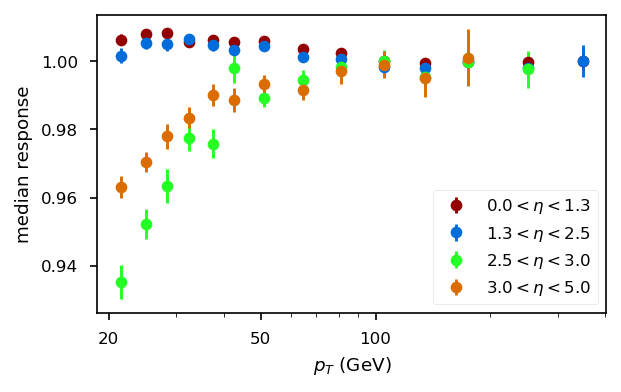

-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_b_L5_DY-JME
N converge =  52 N_not_converge =  0


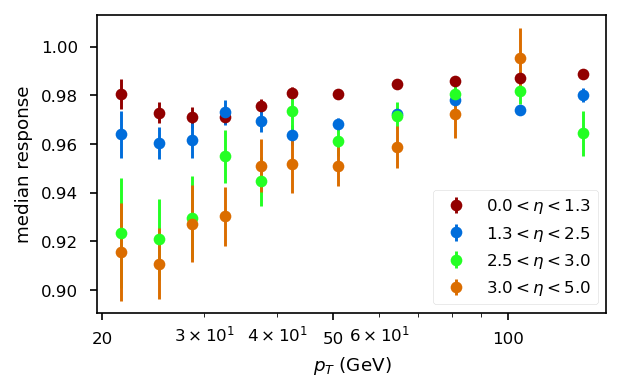

-------------------------
-------------------------
Fitting subsample:  _c
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_c_L5_DY-JME
N converge =  47 N_not_converge =  0


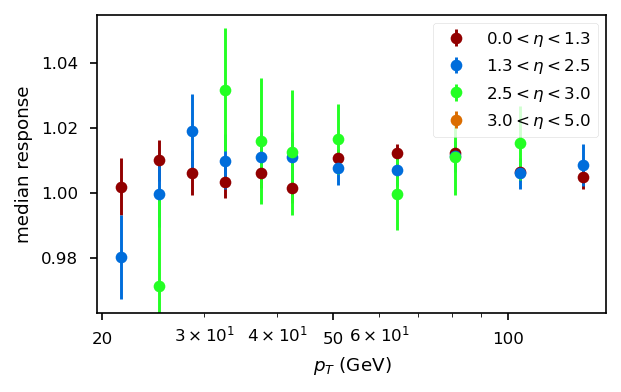

-------------------------
-------------------------
Fitting subsample:  _u
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_u_L5_DY-JME
N converge =  54 N_not_converge =  0


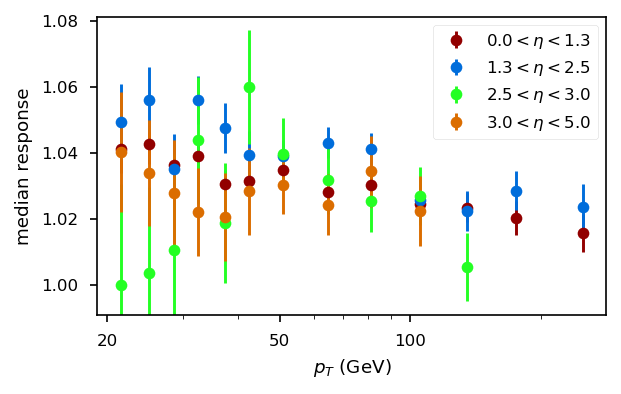

-------------------------
-------------------------
Fitting subsample:  _d
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_d_L5_DY-JME
N converge =  58 N_not_converge =  0


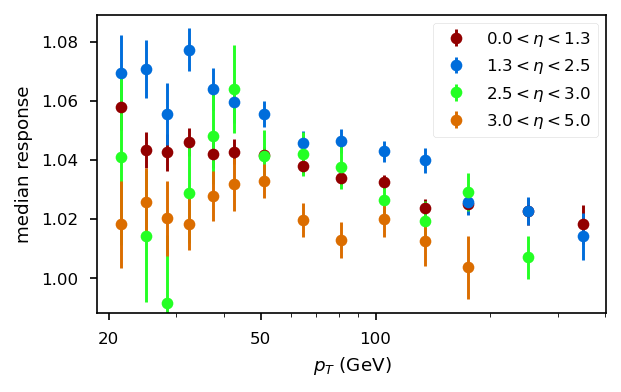

-------------------------
-------------------------
Fitting subsample:  _s
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_s_L5_DY-JME
N converge =  47 N_not_converge =  0


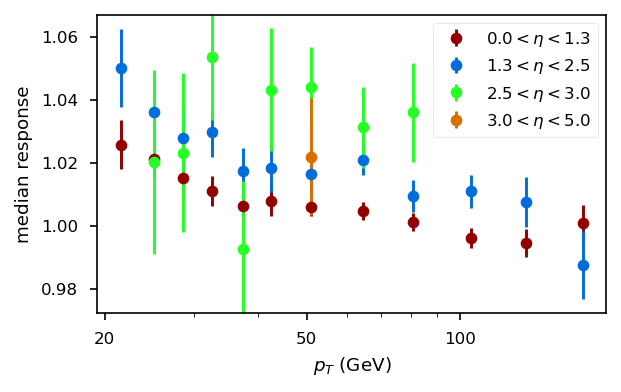

-------------------------
-------------------------
Fitting subsample:  _g
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_g_L5_DY-JME
N converge =  56 N_not_converge =  0


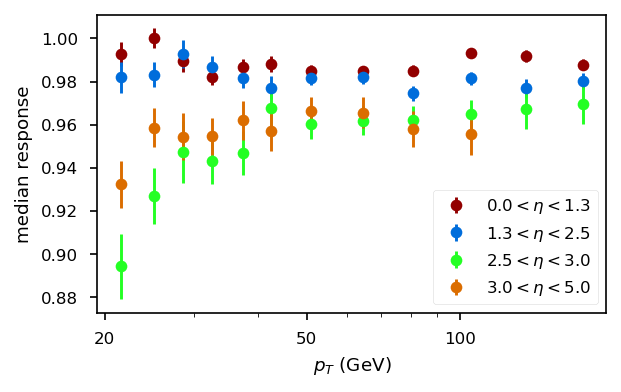

-------------------------
-------------------------
Fitting subsample:  _bbar
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_bbar_L5_DY-JME
N converge =  51 N_not_converge =  0


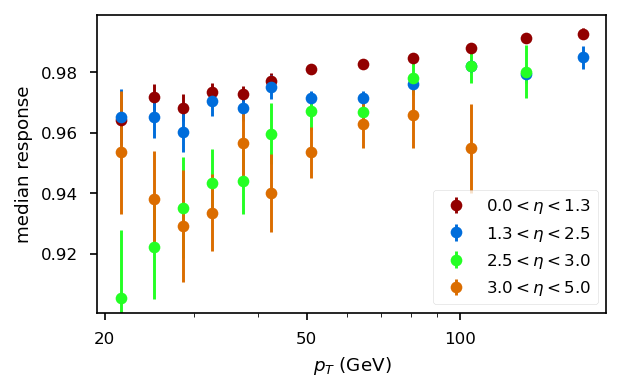

-------------------------
-------------------------
Fitting subsample:  _cbar
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_cbar_L5_DY-JME
N converge =  47 N_not_converge =  0


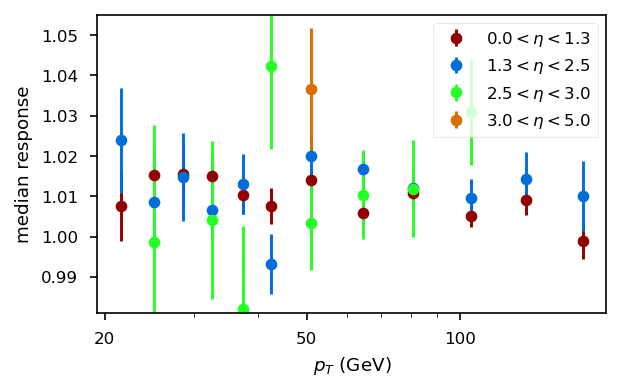

-------------------------
-------------------------
Fitting subsample:  _ubar
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_ubar_L5_DY-JME
N converge =  47 N_not_converge =  0


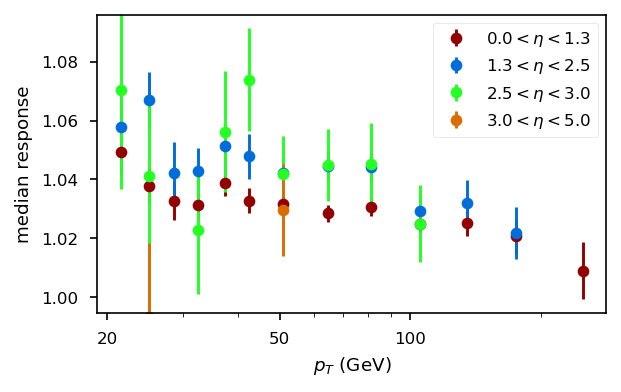

-------------------------
-------------------------
Fitting subsample:  _dbar
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_dbar_L5_DY-JME
N converge =  48 N_not_converge =  0


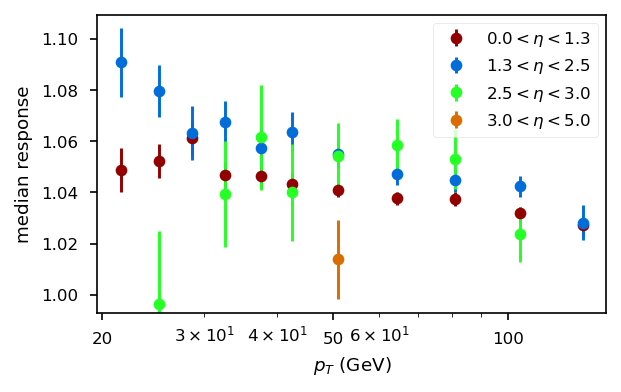

-------------------------
-------------------------
Fitting subsample:  _sbar
Images will be saved under  fig/responses/responses_L5_DY-JME/response_pt_eta_sbar_L5_DY-JME
N converge =  45 N_not_converge =  0


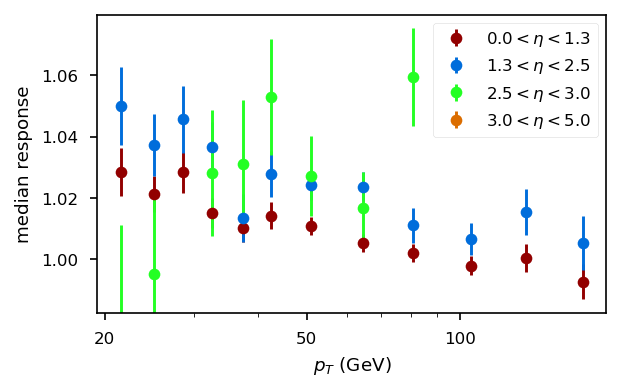

In [161]:
# load_fit_res=False
combine_antiflavour = False
subsamples = ['', '_b', '_c', '_u', '_d', '_s', '_g', '_bbar', '_cbar', '_ubar', '_dbar','_sbar']
# subsamples = ['_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Median", samp)
        meanvar = read_data("MedianVar", samp)
        median = read_data("Median", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        medians.append(median[0][0])
        medianstds.append(medianstd[0][0])
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            pass
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins or one_bin:
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(median, samp, medianstd)

In [ ]:
print('-----'*10)
print("All done. Congrats!")